Tests the CentralizedLunarKF code with an example with plots.

In [ ]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

# np.random.seed(5)

%run ./CentralizedLunarKF.ipynb

**Pre-defined values from Lunar Time-Transfer paper to define Q and R**

In [ ]:
# constant terms, given in Bhamidipati et. al
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5

s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)


def R(N):
    return np.kron(np.eye(N), np.array([[pr_var, 0], [0, prr_var]]))

def R_cf(num_msmts):
    return np.kron(np.eye(sum(num_msmts)), R(1))

if __name__ == '__main__':
    print(R(2))

[[24.40369964  0.          0.          0.        ]
 [ 0.          0.20383392  0.          0.        ]
 [ 0.          0.         24.40369964  0.        ]
 [ 0.          0.          0.          0.20383392]]


In [ ]:
# more constant terms, pertinent to Q matrix
# Q is process noise covariance matrix
# h_0 = 1.4*(10**(-22))
# h_m1 = 2.3*(10**(-26))
# h_m2 = 3.3*(10**(-31))

h_0 = 1.8*(10**(-21))
h_m1 = 6.492*(10**(-22))
h_m2 = 1.37*(10**(-24))

dt = 7

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

Q = (c**2)*np.array([[e1,e2],[e2,e3]])

if __name__ == '__main__':
    print(Q)

[[0.00656212 0.00087641]
 [0.00087641 0.00015093]]


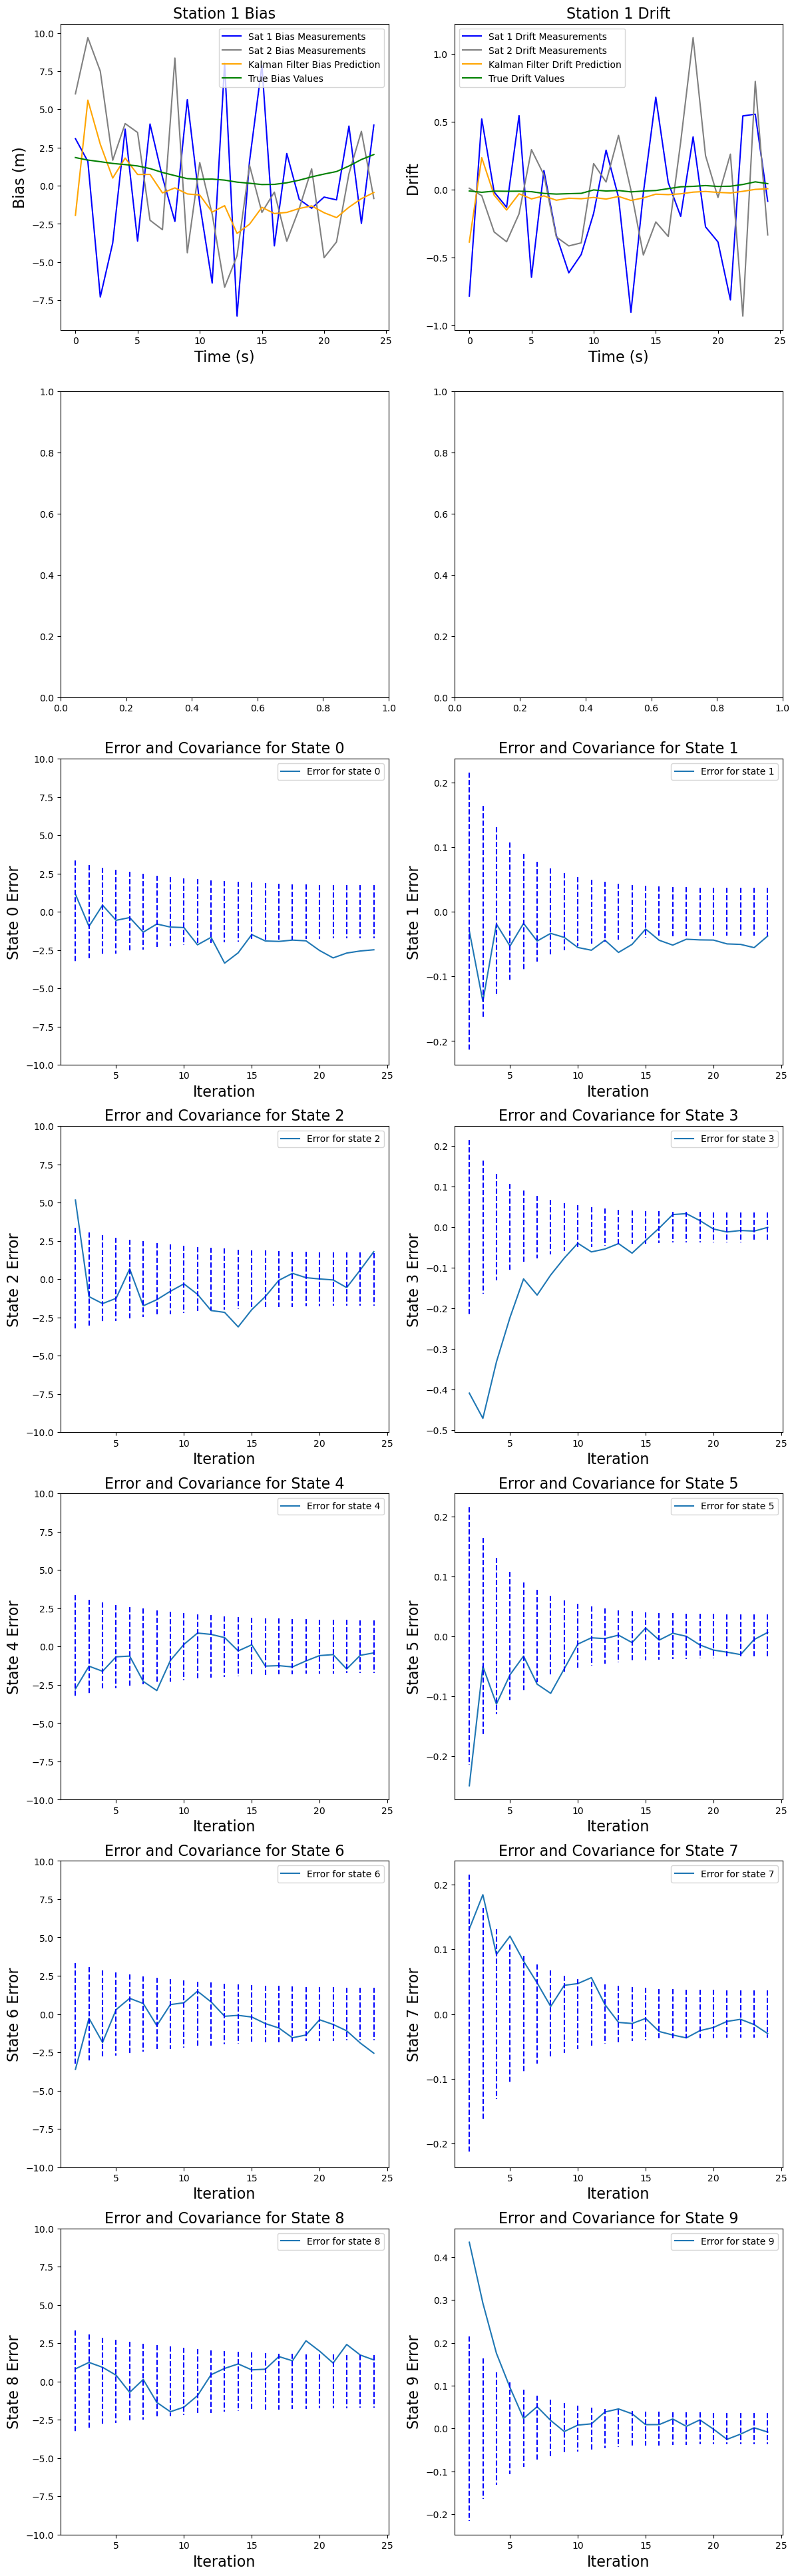

In [ ]:
def example():
    C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
    n = len(C[0])

    iterations = 25

    A = np.kron(np.eye(n),np.array([[1,dt],[0,1]]))

    true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
    true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T

    x0 = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

    # random initial estimates for each node

    x0_dkf = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
    x0_ckf = np.vstack(tuple(x0_dkf))

    F = np.array([[1,dt],[0,1]])
    F_full = np.kron(np.eye(n),F)

    # set up process noise covariance matrix Q
    Q_10x10 = np.kron(np.eye(n),Q)

    P = [100*np.copy(R(1)) for _ in range(n)]
    P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

    kf = KalmanFilter(A = F_full, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_ckf)
    #For the first iteration these are our cross_links

    # Process Noise and Measurement Noise Functions
    Q_full = np.kron(np.eye(n),Q)
    #Process Noise
    def procc_noise():
        return np.linalg.cholesky(Q_full) @ np.random.normal(np.array([[0 for _ in range(2 * n)]]).T)
    def measure_noise(num_msmts):
        return np.linalg.cholesky(R_cf(num_msmts)) @ np.random.normal(np.array([[0 for _ in range(2 * sum(num_msmts))]]).T)

    # Generate initial measurement
    z = (kf.H([2,2,2,2,2])@ x0) + measure_noise([2,2,2,2,2])

    # Initialize the lists to store results
    truth = [x0]
    predictions = [x0_ckf]
    measurements = [z]
    errors = [(x0_ckf-x0)]
    P_hist = [kf.P]

    # Run Kalman Filter for 80 iterations
    iterations = 25
    for i in range(iterations-1):
        truth.append((A@truth[-1]) + procc_noise()) # Get new truth with process noise

        z = (kf.H([2,2,2,2,2]) @ truth[-1]) + measure_noise([2,2,2,2,2]) # Get new measurements with measurement noise
        measurements.append(z)

        kf.update(z,[2,2,2,2,2]) # Correct estimate using measurement

        predictions.append(kf.x) # Record updated estimate and error
        errors.append(kf.x - truth[-1])

        kf.predict() # Predict next step

        P_hist.append(kf.P) # Append the covariance matrix history

    # Creating subplots
    fig,axs = plt.subplots(7,2, figsize=(14, 49))
    for i in range(1):
        # Plot bias and drift measurements, predictions, and true values
        axs[0][0].plot([i for i in range(iterations)],[x[4*i][0] for x in measurements], label = 'Sat 1 Bias Measurements', color = "blue")
        axs[0][0].plot([i for i in range(iterations)],[x[4*i+2][0] for x in measurements], label = 'Sat 2 Bias Measurements', color = "grey")
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in predictions], label = 'Kalman Filter Bias Prediction', color = "orange")
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in truth], label = 'True Bias Values', color = "green")
        axs[0][0].set_xlabel("Time (s)", fontsize = 16)
        axs[0][0].set_ylabel("Bias (m)", fontsize = 16)
        axs[0][0].legend(prop={'size': 10})
        axs[0][0].set_title("Station 1 Bias", fontsize = 16)

        axs[0][1].plot([i for i in range(iterations)],[x[4*i+1][0] for x in measurements], label = 'Sat 1 Drift Measurements', color = "blue")
        axs[0][1].plot([i for i in range(iterations)],[x[4*i+3][0] for x in measurements], label = 'Sat 2 Drift Measurements', color = "grey")
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in predictions], label = 'Kalman Filter Drift Prediction', color = "orange")
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in truth], label = 'True Drift Values', color = "green")
        axs[0][1].set_xlabel("Time (s)", fontsize = 16)
        axs[0][1].set_ylabel("Drift ", fontsize = 16)
        axs[0][1].legend()
        axs[0][1].set_title("Station 1 Drift", fontsize = 16)

        # Convert errors and covariance history to numpy arrays
        errors = np.array(errors).squeeze()
        P_hist = np.array(P_hist)
        t_hist = np.arange(iterations)

        # Plot error and covariance bounds for each state variable
        for k in range(10):
            error_k = errors[2:, k]
            cov_k = np.sqrt(P_hist[2:, k, k])
            row, col = divmod(k, 2)
            axs[row+2, col].plot(t_hist[2:], error_k, label=f'Error for state {k}')
            axs[row+2, col].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([cov_k, -cov_k]), 'b--')
            axs[row+2, col].legend()
            if k%2 == 0:
                axs[row+2, col].set_ylim(-10,10)
            axs[row+2, col].set_xlabel("Iteration", fontsize = 16)
            axs[row+2, col].set_ylabel(f"State {k} Error", fontsize = 16)
            axs[row+2, col].set_title(f"Error and Covariance for State {k}", fontsize = 16)

        plt.show()

if __name__ == '__main__':
    example()